# Analysis of systematic prediction errors in the rgc2lgn model

TODO:

## Setup

In [29]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.decomposition import PCA

# import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.gridspec as gridspec
%matplotlib inline
# %matplotlib notebook

import pdb

## Parameters

In [2]:
# Directories
data_dir = '../data/'
results_dir = '../results/'

# Model type
# % OPTIONS:
# % - 'lin': linear
# % - 'lin_nonneg': linear w non-neg constraint
# % - 'lin_nonneg_exp2': linear with non-neg constraint + two-term exponential
# % - 'lasso': linear model w elastic net regularization
# % - 'glm': Generalized linear model with exponential non-linearity
# % - 'lassoglm': Generalized linear model with exponential non-linearity & elastic net regularization
model_type = 'lin_nonneg'


In [63]:
## Utils functions
# TODO: outsource to utils
def custom_plot_pars():
    """Returns custom plot parameters."""
    plot_pars = {
        'figure.facecolor': 'white',        
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.linewidth': 1.0,
        'axes.titlesize': 20,
        'figure.frameon': False,
   #         ‘figure.autolayout’: True
        'font.cursive': 'Arial',
        'font.serif': 'Arial',
        'font.sans-serif': 'Arial',
        'font.size': 15,
        'figure.figsize': [12.0, 4.0],
        'legend.frameon': False,
        'legend.fontsize': 15,
#         'mathtext.default': 'regular', # avoid DejaVu text formatting (DEFAULT: 'it')
        'pdf.fonttype': 42, # Important for rendering text as text in .pdf savefig
        'ps.fonttype': 3, # Important for rendering text as text in .eps savefig (DEFAULT: 3)
#         'ps.useafm': True,
#         'pdf.use14corefonts': True,
#         'text.usetex': True,
        'svg.fonttype': 'none', # Important for rendering text as text in .svg savefig
        'xtick.major.size': 6.5,
        'ytick.major.size': 6.5,
          }
    return plot_pars


def every_nth_ticklabel(axishandle, every_nth=2, xy_axis='xy'):
    """Shows only every nth ticklabel on specified axis object and axis dimension."""    
    
    if (xy_axis == 'x') or (xy_axis == 'xy'):
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
#             pdb.set_trace()
            if label.get_text() == '': # this is to avoid invisible '' ticks before the first tick
                n += 1
            if n % every_nth != 0:
                label.set_visible(False)
    if (xy_axis == 'y') or (xy_axis == 'xy'):
        for n, label in enumerate(ax.yaxis.get_ticklabels()):
            if label.get_text() == '': # this is to avoid invisible '' ticks before the first tick
                n += 1
            if n % every_nth != 0:
                label.set_visible(False)
                
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [61]:
plot_pars = custom_plot_pars()
rcParams.update(plot_pars)

# sns.set_style("white") # Remove background grid (sets for all plots?)
# Standard color map (reverse) (check alternative setup methods later)
# sns.set_palette('Blues_r')

## Load & transform data

In [5]:
ffname = data_dir+'model_'+model_type+'.mat'
print('Loading model:', ffname)
model = loadmat(ffname)

Loading model: ../data/model_lin_nonneg.mat


In [6]:
# Get dLGN cell responses and model predictions from RGC clusters
resp_orig = model['model_units']
pred_orig = model['model_y_hat']

print("Responses shape: (cell, time, cross-val) =", resp_orig.shape)
print("Predictions shape: (cell, time, cross-val) =", pred_orig.shape)

# Average across cross-validations
resp = np.mean(resp_orig, 2)
pred = np.mean(pred_orig, 2)

# Exclude cell with no model
resp = resp[~np.all(resp == 0, axis=1)]
pred = pred[~np.all(pred == 0, axis=1)]
print("Final responses shape: (cell, time) =", resp.shape)
print("Final predictions shape: (cell, time) =", pred.shape)

Responses shape: (cell, time, cross-val) = (815, 249, 1000)
Predictions shape: (cell, time, cross-val) = (815, 249, 1000)
Final responses shape: (cell, time) = (814, 249)
Final predictions shape: (cell, time) = (814, 249)


In [7]:
# Get time vector
rgc = model['rgc']
t = rgc[0,0][0].T
print(t.shape)

(249, 1)


## Create summary plot

In [46]:
rcParams['axes.titlesize']
rcParams['mathtext.default'] = 'regular'

In [62]:
gs = gridspec.GridSpec(5, 8)

plt.figure(figsize=(16,9))


### Plot example cell
ndx = 451 # [153]
ax1 = plt.subplot(gs[:2,2:7]) # single specified location
ax1.plot(t, resp[ndx,:], 'k', label='cell response')
ax1.plot(t, pred[ndx,:], label='model prediction')

plt.ylabel('Norm. $\Delta$F/F', fontsize=rcParams['axes.titlesize'])
plt.legend()
ax1.tick_params(labelleft=True, labelbottom=False)
# every_nth_ticklabel(ax, every_nth=2)

## Add text to the left of the plot (do as new plot with empty axis)
ax01 = plt.subplot(gs[:2,:2]) # single specified location
plt.title('Example cell')
ax01.get_xaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax01.set_frame_on(False)

### Compute residuals (all cells)
res = resp-pred
ax2 = plt.subplot(gs[2,2:7]) # single specified location

plt.plot(t, res[ndx,:], 'grey', label='residuals = response - prediction')
plt.legend(loc='lower right')
ax2.tick_params(labelleft=True, labelbottom=False)
ax2.set_ylim([-0.5,0.5])

## Add text to the left of the plot (do as new plot with empty axis)
ax02 = plt.subplot(gs[2,:2]) # single specified location
plt.title('Residuals')
ax02.get_xaxis().set_visible(False)
ax02.get_yaxis().set_visible(False)
ax02.set_frame_on(False)

### Compute PCA on residuals
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(res)

ax3 = plt.subplot(gs[3:5,0:2]) # specify plot location

plt.plot(np.arange(ncomp)+1, pca.explained_variance_ratio_, '.', color='k', markersize=10)
plt.plot(1, pca.explained_variance_ratio_[0], '.', color='sienna', markersize=10)
plt.plot(2, pca.explained_variance_ratio_[1], '.', color='sandybrown', markersize=10)

plt.ylabel('Explained \nvariance ratio', fontsize=20)
plt.xlabel('Principal component', fontsize=20)
plt.title('PCA')

ax = plt.gca()
every_nth_ticklabel(ax, every_nth=2, xy_axis='y')


### Plot first and second PCA component

ax4 = plt.subplot(gs[3:5,2:7]) # single specified location

plt.plot(t, pca.components_[0,:].T, 'sienna', label='1st PC')
plt.plot(t, pca.components_[1,:].T, 'sandybrown', label='2nd PC')
plt.xlabel('Time (s)', fontsize=rcParams['axes.titlesize'])
plt.legend(loc='lower right')

ax = plt.gca()
every_nth_ticklabel(ax, every_nth=2, xy_axis='x')

plt.tight_layout()

plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.png')
plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.eps')
plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.svg')
plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.pdf')

RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11a84c598> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 



RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 



In [43]:
rcParams['xtick.labelsize'] = 'medium'

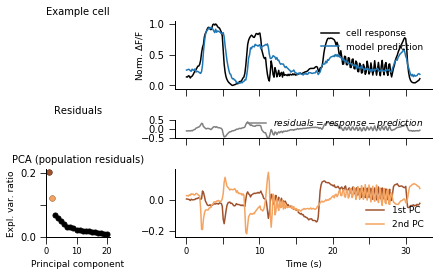

In [25]:
# Set pars
rcParams['xtick.labelsize'] = 'small'

# Create figure grid and figure
gs = gridspec.GridSpec(5, 8)
plt.figure(figsize=cm2inch(18,10))


### Plot example cell
ndx = 451 # [153]
ax1 = plt.subplot(gs[:2,2:7]) # single specified location
ax1.plot(t, resp[ndx,:], 'k', label='cell response')
ax1.plot(t, pred[ndx,:], label='model prediction')

plt.ylabel('Norm. $\Delta$F/F', fontsize=9)
plt.legend(fontsize=9)
ax1.tick_params(labelleft=True, labelbottom=False)
# every_nth_ticklabel(ax, every_nth=2)

## Add text to the left of the plot (do as new plot with empty axis)
ax01 = plt.subplot(gs[:2,:2]) # single specified location
plt.title('Example cell', fontsize=10)
ax01.get_xaxis().set_visible(False)
ax01.get_yaxis().set_visible(False)
ax01.set_frame_on(False)

### Compute residuals (all cells)
res = resp-pred
ax2 = plt.subplot(gs[2,2:7]) # single specified location

plt.plot(t, res[ndx,:], 'grey', label='$residuals = response - prediction$')
plt.legend(loc='lower right', fontsize=9)
ax2.tick_params(labelleft=True, labelbottom=False)
ax2.set_ylim([-0.5,0.5])

## Add text to the left of the plot (do as new plot with empty axis)
ax02 = plt.subplot(gs[2,:2]) # single specified location
plt.title('Residuals', fontsize=10)
ax02.get_xaxis().set_visible(False)
ax02.get_yaxis().set_visible(False)
ax02.set_frame_on(False)

### Compute PCA on residuals
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(res)

ax3 = plt.subplot(gs[3:5,0:2]) # specify plot location

plt.plot(np.arange(ncomp)+1, pca.explained_variance_ratio_, '.', color='k', markersize=10)
plt.plot(1, pca.explained_variance_ratio_[0], '.', color='sienna', markersize=10)
plt.plot(2, pca.explained_variance_ratio_[1], '.', color='sandybrown', markersize=10)

plt.ylabel('Expl. var. ratio', fontsize=9)
plt.xlabel('Principal component', fontsize=9)
plt.title('PCA (population residuals)', fontsize=10)

ax = plt.gca()
every_nth_ticklabel(ax, every_nth=2, xy_axis='y')


### Plot first and second PCA component

ax4 = plt.subplot(gs[3:5,2:7]) # single specified location

plt.plot(t, pca.components_[0,:].T, 'sienna', label='1st PC')
plt.plot(t, pca.components_[1,:].T, 'sandybrown', label='2nd PC')
plt.xlabel('Time (s)', fontsize=9)
plt.legend(loc='lower right', fontsize=9)

ax = plt.gca()
every_nth_ticklabel(ax, every_nth=2, xy_axis='x')

plt.tight_layout()

plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.png')
plt.savefig(results_dir+'model_systematic_errors/'+'missing_transients.eps')

In [33]:
rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'ax